In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate normal student performance data (95% of students)
num_normal = 950
attendance = np.random.normal(loc=85, scale=5, size=num_normal)  # Mean 85%, SD 5%
assignment_score = np.random.normal(loc=80, scale=10, size=num_normal)  # Mean 80, SD 10
exam_score = np.random.normal(loc=75, scale=15, size=num_normal)  # Mean 75, SD 15
study_hours = np.random.normal(loc=10, scale=2, size=num_normal)  # Mean 10 hours, SD 2

# Generate anomalous student performance data (5% of students)
num_anomalies = 50
attendance_anomalous = np.random.uniform(30, 60, num_anomalies)  # Very low attendance
assignment_score_anomalous = np.random.uniform(20, 50, num_anomalies)  # Poor assignment scores
exam_score_anomalous = np.random.uniform(30, 50, num_anomalies)  # Poor exam scores
study_hours_anomalous = np.random.uniform(2, 5, num_anomalies)  # Very low study hours

# Combine normal and anomalous data
attendance = np.concatenate([attendance, attendance_anomalous])
assignment_score = np.concatenate([assignment_score, assignment_score_anomalous])
exam_score = np.concatenate([exam_score, exam_score_anomalous])
study_hours = np.concatenate([study_hours, study_hours_anomalous])

# Create DataFrame
df = pd.DataFrame({
    'attendance': attendance,
    'assignment_score': assignment_score,
    'exam_score': exam_score,
    'study_hours': study_hours
})

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
# Split into training (80%) and test (20%) sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

In [4]:
# Define the autoencoder model
input_dim = X_train.shape[1]

# Encoder
input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='relu')(input_layer)
encoded = layers.Dense(4, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Compile the model
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0413 - val_loss: 0.0382
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - val_loss: 0.0358
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - val_loss: 0.0334
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0327 - val_loss: 0.0309
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309 - val_loss: 0.0279
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.0236
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - val_loss: 0.0196
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0163
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0141
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0125
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_lo

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


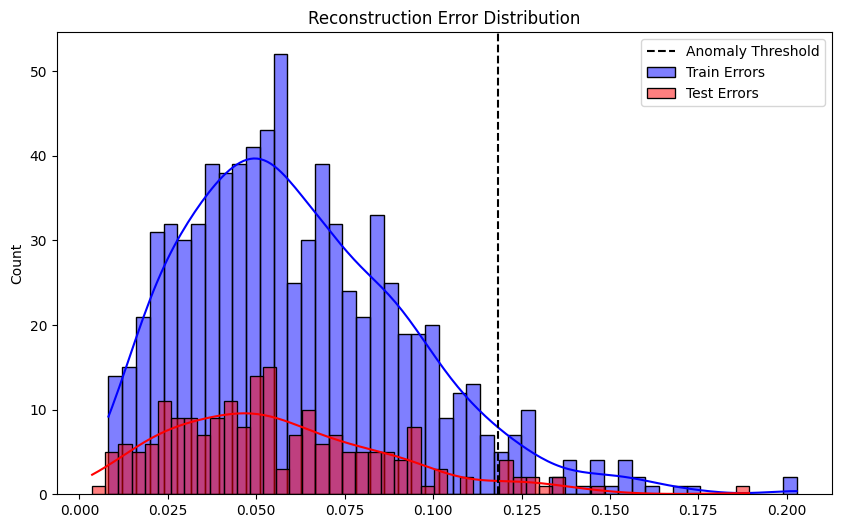

In [5]:
# Compute reconstruction error
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_errors = np.mean(np.abs(X_train - X_train_pred), axis=1)
test_errors = np.mean(np.abs(X_test - X_test_pred), axis=1)

# Visualize error distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_errors, bins=50, kde=True, label="Train Errors", color='blue')
sns.histplot(test_errors, bins=50, kde=True, label="Test Errors", color='red')
plt.axvline(np.percentile(train_errors, 95), color='black', linestyle='dashed', label="Anomaly Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [6]:
# Define anomaly threshold (95th percentile of training errors)
threshold = np.percentile(train_errors, 95)

# Detect anomalies
anomalies = test_errors > threshold

# Create DataFrame with results
df_test = pd.DataFrame(X_test, columns=df.columns)
df_test['Anomaly'] = anomalies

# Print detected anomalies
print(df_test[df_test['Anomaly'] == True])

     attendance  assignment_score  exam_score  study_hours  Anomaly
25     0.863113          0.698348    0.571067     0.236962     True
27     0.698479          0.616807    0.201920     0.726802     True
83     0.755926          0.417445    0.484940     0.913797     True
93     0.787429          0.624723    0.355102     0.762246     True
98     1.000000          0.616572    0.588362     0.454635     True
100    0.640438          0.512140    0.277833     0.755331     True
122    0.751007          0.887945    0.671110     0.376516     True
124    0.019557          0.286967    0.079318     0.028808     True
146    0.793549          0.591828    0.774548     0.305570     True
147    0.823793          0.834273    0.731434     0.348419     True
188    0.551822          0.719459    0.266660     0.607469     True
197    0.773241          0.580983    0.254962     0.710054     True
199    0.677784          0.338922    0.178625     0.541501     True
